© 2025 Zitao Yang*, Rebecca J. Rousseau*, Sara D. Mahdavi*, Hernan G. Garcia, and Rob Phillips, *The Dynamics of Inducible Genetic Circuits*. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).
*: These authors contributed equally to this work.
___

# Timescale for relaxation to steady state in auto-activation

This notebook generates the plots shown in Figure 13 as well as Appendix Figure 33 of the paper. These figures demonstrate the times required to relax to steady state depending on initial conditions.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from scipy.stats import linregress
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

import matplotlib.transforms as mtransforms
from matplotlib.patches import FancyArrowPatch

In [4]:
delE=4.5
Ka=1.4*10**(-4)
Ki=5.3*10**(-7)
K_c=Ka/Ki

fixed_r0 = 0.1
fixed_r1 = 1
fixed_r2 = 20
fixed_w = 7
fixed_gamma = 1

pact = 0.07

custom_cmap = ListedColormap(["#FFCCCC", "#ADD8E6"])

def pAct(c, K_c=K_c, delE=delE):
    """ probability of repressor/activator being active

    Parameters:
        - c: effector concentration
        - K_c: ratio of dissociation constants for active vs. inactive states
        - delE: energy difference between inactive and active state
    """

    p= (1 + c)**2 / ((1 + c)**2 + np.exp(-delE)*(1 + c*K_c)**2)
    return p

def pAct_inv(p, K_c=K_c, delE=delE):
    """Inverse of pAct: returns effector concentration c given activation probability p"""
    a = np.sqrt(1/p - 1) * np.exp(delE / 2)
    c = (a - 1) / (K_c - a)
    return c

## Helper functions for evaluating the dynamical equation

$$
\frac{d\bar{A}}{d\bar{t}}=-\gamma \bar{A} + \frac{r_0+2r_1p_{act}\bar{A}+r_2 \omega(p_{act}\bar{A})^2}{1+2p_{act}\bar{A}+\omega(p_{act}\bar{A})^2}
$$





In [6]:
def f_prime(A, pAct=0.07, r0=fixed_r0, r1=fixed_r1, r2=fixed_r2, omega=fixed_w, gamma=fixed_gamma):
    return -gamma + (2 * pAct * (-r0 + r1 + A * pAct * (-r0 + r2 + A * pAct * (-r1 + r2)) * omega)) / \
                   (1 + A * pAct * (2 + A * pAct * omega))**2

In [7]:
def is_stable(A, pact, w, r0, r1, r2):
  """ Define stability at a given activator concentration and effector concentration

  Parameters:
      - A: dimensionless activator concentration
      - pact: probability of A being active
      - w: cooperativity
      - r0: value for rate r0 (dimensionless)
      - r1: value for rate r1 (dimensionless)
      - r2: value for rate r2 (dimensionless)
  """
  same_sign_than_fprime = (-1 + pact * (-4 * A * (1 + A * pact) - 2 * r0 + 2 * r1 -
                      2 * A * pact * (A + r0 + A * pact * (2 * A + r1 - r2) -
                      r2) * w - A**4 * pact**3 * w**2))
  if same_sign_than_fprime>0:
    return True
  else:
    return False

In [8]:
# polynomial giving the steady states
def polynomial_coefficients(pact, w, r0, r1, r2):
    """ Define an array containing the coefficients of the polynomial generated 
    from setting the auto-activation dynamical equation equal to zero
    to solve for steady states

    Parameters:
        - pact: probability of A being active
        - w: cooperativity
        - r0: r_0, basal rate of activator mRNA expression, i.e., expression rate
          for unbound regulatory state (dimensionless)
        - r1: r_1, rate of activator mRNA expression in regulatory state with
          one bound activator (dimensionless)
        - r2: r_2, rate of activator mRNA expression in regulatory state with
          two bound activators (dimensionless)
    """
    return [w * pact**2,
            (2 * pact - w * r2 * pact**2),
            (1 - 2 * r1 * pact),
            -r0]

# Function to find roots for varying pact
def find_real_positive_roots(pact, w, r0, r1, r2):
    """ Calculate real positive roots for the polynomial steady state condition,
    varying pact

    Parameters:
        - pact: probability of A being active
        - w: cooperativity
        - r0: r_0, basal rate of activator mRNA expression, i.e., expression rate
          for unbound regulatory state (dimensionless)
        - r1: r_1, rate of activator mRNA expression in regulatory state with
          one bound activator (dimensionless)
        - r2: r_2, rate of activator mRNA expression in regulatory state with
          two bound activators (dimensionless)
    """
    coeffs = polynomial_coefficients(pact, w, r0, r1, r2)
    roots = np.roots(coeffs)
    # Filter for real and positive roots
    real_positive_roots = roots[np.isreal(roots) & (roots > 0)]
    return real_positive_roots

In [9]:
def auto_act_A_t_profile(initial_conditions, pact=0.07, w=fixed_w, r0=fixed_r0, r1=fixed_r1, r2=fixed_r2):
  """ Evolve from an initial activator concentration to its final steady state,
  and return the solution for activator expression at the final time point

  Parameters:
      - initial_conditions: initial (dimensionless) concentration of activator
      - pact: probability of A being active
      - w: cooperativity
      - r0: r_0, basal rate of activator mRNA expression, i.e., expression rate
      for unbound regulatory state (dimensionless)
      - r1: r_1, rate of activator mRNA expression in regulatory state with
      one bound activator (dimensionless)
      - r2: r_2, rate of activator mRNA expression in regulatory state with
      two bound activators (dimensionless)
  """
  def system(t, A):
    dA_dt = -A + (r0 + 2 * r1 *pact*A + r2*w*(pact*A)**2 ) / (1+ 2*pact*A + w*(pact*A)**2)
    return [dA_dt]
  t_span = (0, 20)  # Solve from t=0 to t=100
  t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Points at which to evaluate the solution

  # Solve the system of equations
  solution = solve_ivp(system, t_span, initial_conditions, t_eval=t_eval)

  # Extract the solution at long time (last time point)
  A_of_t = solution.y[0]

  return A_of_t, t_eval


In [10]:
def time_scale(seady_states,f_of_t,time,type_of_approach='curve_fit',thresh=0.63):
  """ Calculate the timescale for evolving to steady state from the time it takes
  for the system to approach steady state by a threshold value

  Parameters:
      - seady_states: steady state expression
      - f_of_t: trajectory of system evolution to final activator concentration
  """
  f_0=f_of_t[0]
  f_inf=f_of_t[-1]
  t_0=time[0]
  i_ss = np.argmin(np.abs(f_inf-seady_states))
  A_inf = seady_states[i_ss]
  if type_of_approach == 'curve_fit':
    #y=np.log(np.abs(f_of_t-A_inf))
    def exp_relax(t, tau):
      return A_inf + (f_0 - A_inf) * np.exp(-(t-t_0) / tau)
    popt, pcov = curve_fit(exp_relax, time, f_of_t, p0=[1])
    tau_fit = popt
    return tau_fit
  if type_of_approach == 'threshold':
    f_target = thresh * (f_inf-f_0) + f_0
    i_t = np.argmin(np.abs(f_of_t - f_target))
    return time[i_t]



# Fig. 13

This figure captures the time evolution of activator concentration from various initial conditions, and determines how the timescale for relaxation to steady state changes with different initial conditions.

## (A): Examples of relaxation trajectories

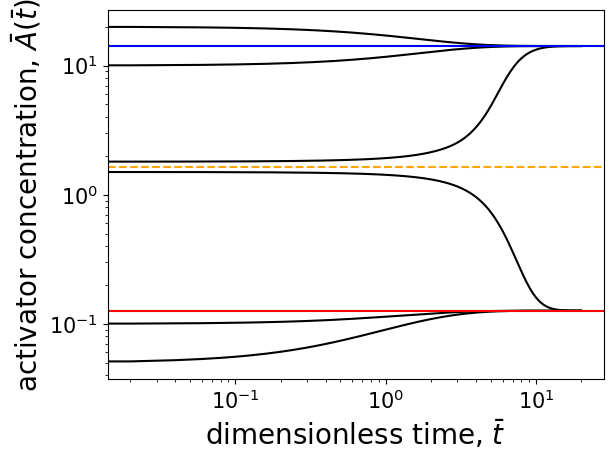

In [12]:
A_fixed_points = find_real_positive_roots(pact, fixed_w, fixed_r0, fixed_r1, fixed_r2)
A1,A3=min(A_fixed_points),max(A_fixed_points)
A0_max=A3*20

A0_05,t=auto_act_A_t_profile([0.05], pact)
A0_1,t=auto_act_A_t_profile([0.1], pact)
A1_5,t=auto_act_A_t_profile([1.5], pact)
A1_8,t=auto_act_A_t_profile([1.8], pact)
A14,t=auto_act_A_t_profile([10], pact)
A15,t=auto_act_A_t_profile([20], pact)
plt.plot(t,A0_05 ,'k')
plt.plot(t,A0_1, 'k')
plt.plot(t,A1_5, 'k')
plt.plot(t,A1_8, 'k')
plt.plot(t,A14, 'k')
plt.plot(t,A15, 'k')
plt.xscale('log')
plt.yscale('log')

plt.ylabel(r'activator concentration, $\bar{A}(\bar{t})$',size=20)
plt.xlabel(r'dimensionless time, $\bar{t}$',size=20)

plt.tick_params(axis='both', which='major', labelsize=15)  # adjust tick label size

plt.axhline(A_fixed_points[0], color ='b', label = ' stable fixed point')
plt.axhline(A_fixed_points[1], color='orange', linestyle = '--', label = ' unstable fixed point')
plt.axhline(A_fixed_points[2],color='r')
plt.show()

Note that the horizontal lines indicate (1) blue stable steady state at high activator concentration, (2) yellow unstable steady state, and (3) red stable steady state at low activator concentration.

## (B): Relaxation timescales

In [15]:
#Define a list of initial activator concentrations A0, with points which are not too close from stable steady state to avoid absence of transient
index_to_remove = []
A0_list=np.logspace(-2 , np.log10(A0_max), 1000)
for i in range(len(A0_list)):
  if abs(A0_list[i]-A1)<1e-3 or abs(A0_list[i]-A3)<1e-2:
    index_to_remove += [i]

index_to_remove = np.array(index_to_remove)
A0_list = np.delete(A0_list, index_to_remove)

In [16]:
# Compute fixed points
A_fixed_points = find_real_positive_roots(pact, fixed_w, fixed_r0, fixed_r1, fixed_r2)
A1,A3=min(A_fixed_points),max(A_fixed_points)
# Compute the relaxation times
tau_A_cf_list = []
for iA0 in range(len(A0_list)):
  A0 = A0_list[iA0]
  A_of_t, time = auto_act_A_t_profile([A0])
  tau_A_cf = time_scale(A_fixed_points,A_of_t,time,type_of_approach='curve_fit')
  tau_A_cf_list += [tau_A_cf]

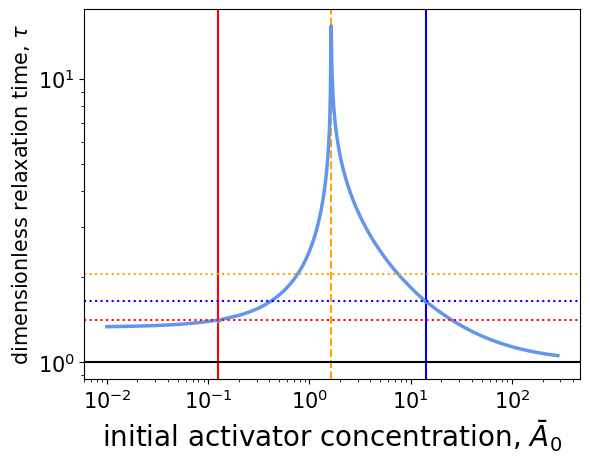

In [17]:
plt.axvline(A_fixed_points[0], color ='b', label = ' stable fixed point')
plt.axvline(A_fixed_points[1], color='orange', linestyle = '--', label = ' unstable fixed point')
plt.axvline(A_fixed_points[2],color='r')

plt.plot(A0_list,tau_A_cf_list, color = "cornflowerblue", label = 'curve fit', linewidth=2.5)

tau_0=1/np.abs(f_prime(A_fixed_points[0]))
tau_1=1/np.abs(f_prime(A_fixed_points[1]))
tau_2=1/np.abs(f_prime(A_fixed_points[2]))

plt.axhline(tau_0, color ='b', linestyle=':')
plt.axhline(tau_1, color='orange', linestyle=':')
plt.axhline(tau_2,color='r', linestyle=':')
plt.axhline(1,color='k', label=r'$\gamma$')

plt.tick_params(axis='both', which='major', labelsize=15) 
plt.xlabel(r'initial activator concentration, $\bar{A}_0$',size=20)
plt.ylabel(r'dimensionless relaxation time, $\tau$',size=15)
plt.xscale('log')
plt.yscale('log')
plt.show()

The system's three possible steady states are denoted by vertical lines of the same color as the previous figure. Horizontal lines denote the timescales specifically associated with each steady state activator concentration (color coded accordingly).

# Appendix

# Fig. 33

This figure examines the difference between threshold and curve fit approaches to defining the change in relaxation timescale as a function of initial activator concentration.

In [20]:
list_thresh = np.linspace(0.5, 0.99, 10)
tau_A_cf_list = []
tau_A_thresh_list = np.zeros((len(list_thresh),len(A0_list)))
norm = mcolors.Normalize(vmin=0, vmax=len(list_thresh))

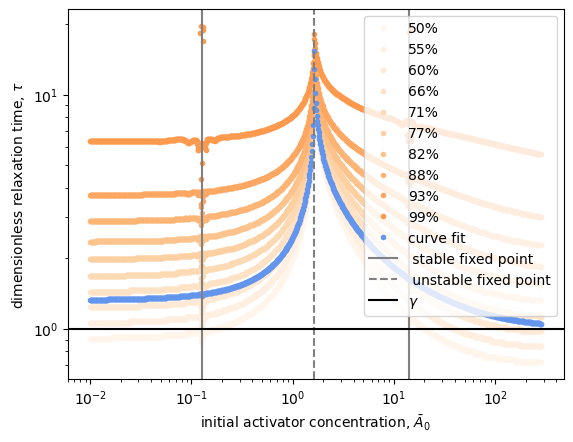

In [21]:
for it in range(len(list_thresh)):
  t = list_thresh[it]
  for iA0 in range(len(A0_list)):
    A0 = A0_list[iA0]
    A_of_t, time = auto_act_A_t_profile([A0])
    tau_A_thresh = time_scale(A_fixed_points,A_of_t,time,type_of_approach='threshold',thresh=t)
    if it==0:
      tau_A_cf = time_scale(A_fixed_points,A_of_t,time,type_of_approach='curve_fit')
      tau_A_cf_list += [tau_A_cf]
    tau_A_thresh_list[it][iA0] = tau_A_thresh
  c = plt.cm.Oranges(norm(it) * 0.5)
  plt.plot(A0_list,tau_A_thresh_list[it], marker = '.', color = c, linestyle='None', label = str(int(t*100))+'%')

plt.plot(A0_list,tau_A_cf_list, marker = '.', color = "cornflowerblue", linestyle='None', label = 'curve fit')

plt.xlabel(r'initial activator concentration, $\bar{A}_{0}$')
plt.ylabel(r'dimensionless relaxation time, $\tau$')
plt.xscale('log')
plt.yscale('log')

plt.axvline(A_fixed_points[0], color ='gray', label = ' stable fixed point')
plt.axvline(A_fixed_points[1], color='gray', linestyle = '--', label = ' unstable fixed point')
plt.axvline(A_fixed_points[2],color='gray')

plt.axhline(1,color='k', label=r'$\gamma$')

plt.legend()
plt.show()